<a href="https://colab.research.google.com/github/cornpip/lab/blob/main/imgsound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

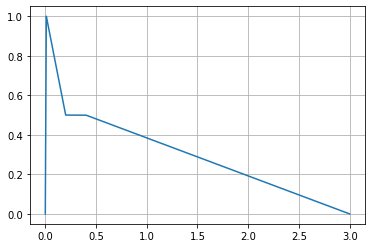

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import math
from scipy.io.wavfile import write
from scipy import signal

class Eenvelope:
  def __init__(self):
    self.envelope = []
    self.t_option = []
  def Attack(self, x, t1):
    m = 1/t1
    y = m*x
    return y

  def Decay(self, x, t1, t2, slevel):
    m = (1-slevel)/(t2-t1)
    y = -m*(x-t1) + 1
    return y

  def Sustain(self, slevel):
    y = slevel
    return y

  def Release(self, x, t3, t4, slevel):
    m = slevel/(t4-t3)
    y = -m*(x-t3)+slevel
    return y

  def t_option(self, t1, t2, t3, t4):
    return [t1, t2, t3, t4]

  def result(self, fs, t1, t2, t3, t4, slevel):
    t = np.arange(0, t4, 1/fs)
    for i in t:
      if (i < t1):
        self.envelope.append(self.Attack(i, t1))
      elif (t1 <= i < t2):
        self.envelope.append(self.Decay(i, t1, t2, slevel))
      elif (t2 <= i < t3):
        self.envelope.append(self.Sustain(slevel))
      elif (t3 <= i <= t4):
        self.envelope.append(self.Release(i, t3, t4, slevel))
    self.t_option = [t1, t2, t3, t4]
    return self.envelope, self.t_option

fs = 10e4

piano = Eenvelope()
piano_en, piano_opt = piano.result(fs, 0.01, 0.2, 0.4, 3, 0.5)

t =np.arange(0, 3, 1/fs)
plt.plot(t, piano_en)
plt.grid()
plt.show()

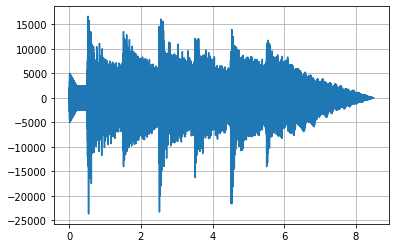

In [9]:
first_oct = 65.4064 ## 2옥타브부터

img = cv2.imread('/test1.PNG')
img1 = img.copy()

hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
his_V, bin_V = np.histogram(v, 3) ## 4옥타브까지 first_f0

hisV_max_index = np.argmax(his_V)

his_S, bin_S = np.histogram(s, 12)
hisS_max_index = np.argmax(his_S)

sound_oct = first_oct * 2 ** (hisV_max_index)
first_f0 = sound_oct * 2 ** (hisS_max_index/12)

f0_key = []
for i in range(13):
  if( i == 0 ):
    f0_key.append(first_f0)
  else :
    f0_key.append(f0_key[-1] * 2 **(1/12))

rowmax = math.trunc(img1.shape[0])
row = math.trunc(img1.shape[0]/6)
columnmax = math.trunc(img1.shape[1])
column = math.trunc(img1.shape[1]/6)

edge = []
edge.append(img1[0:row]) # 위
edge.append(img1[row:rowmax-row, 0:column]) # 왼쪽
edge.append(img1[row:rowmax-row, columnmax-column:]) # 오른쪽
edge.append(img1[rowmax-row:]) # 아래

edge_hisH = np.zeros(2)
edge_hisS = np.zeros(13)
edge_hisV = np.zeros(2)
for i,j in enumerate(edge):
  hsv = cv2.cvtColor(j, cv2.COLOR_BGR2HSV)
  h,s,v = cv2.split(hsv)
  hisH, bin = np.histogram(h, 2) # 주법 2개 중 택1
  hisS, bin2 = np.histogram(s, 13) # f0_key 중 하나
  hisV, bin3 = np.histogram(v, 2) # major, minor 중 택1

  edge_hisH += hisH
  edge_hisS += hisS
  edge_hisV += hisV

E_Hmax_index = np.argmax(edge_hisH)
E_Smax_index = np.argmax(edge_hisS)
E_Vmax_index = np.argmax(edge_hisV)

technic = ""
if(E_Hmax_index == 0):
  technic = "Arpeggio"
else:
  technic = "onefive"

chordtone = ""
if(E_Vmax_index == 0):
  chordtone = "major"
else:
  chordtone = "minor"

sec_f0 = f0_key[E_Smax_index]
sec_f0_pop = f0_key.pop(E_Smax_index)

t = np.arange(0, 3, 1/fs)
tec_sig = []
t_sig_1, t_sig_2, t_sig_3 = [], [], []

final_time = 8.5
sta_time = 0.5

fir_tune = signal.sawtooth(2*np.pi*first_f0*t, 1/2) * piano_en
fir_sig = np.zeros(int(final_time * fs))
fir_sig[0:int(3*fs)] = fir_tune

if(technic == "Arpeggio"):
  tec_sig_1 = signal.sawtooth(2*np.pi*sec_f0/4*t, 1/2) * piano_en
  t_sig_1 = np.zeros(int(final_time * fs))
  t_sig_1[int((sta_time + 0)*fs):int((sta_time + 3)*fs)] = tec_sig_1

  tec_sig_2 = signal.sawtooth(2*np.pi*sec_f0/4*2**(7/12)*t, 1/2) * piano_en
  t_sig_2 = np.zeros(int(final_time * fs))
  t_sig_2[int((sta_time + 0.5)*fs):int((sta_time + 3.5)*fs)] = tec_sig_2

  tec_sig_3 = signal.sawtooth(2*np.pi*sec_f0/2*t, 1/2) * piano_en
  t_sig_3 = np.zeros(int(final_time * fs))
  t_sig_3[int((sta_time + 1)*fs):int((sta_time + 4)*fs)] = tec_sig_3

  tec_sig = t_sig_1 + t_sig_2 + t_sig_3

elif(technic == "onefive"):
  tec_sig_1 = (signal.sawtooth(2*np.pi*sec_f0/4*t, 1/2) + signal.sawtooth(2*np.pi*(sec_f0/4)*2**(7/12)*t, 1/2)) * piano_en
  tec_sig = np.zeros(int(final_time * fs))
  tec_sig[int((sta_time + 0)*fs):int((sta_time + 3)*fs)] = tec_sig_1 

sec_f0_3, sec_f0_5 = 0, 0

if(chordtone == "major"):
  sec_f0_3 = sec_f0 *2**(4/12)
  sec_f0_5 = sec_f0 *2**(7/12)

elif(chordtone == "minor"):
  sec_f0_3 = sec_f0 *2**(3/12)
  sec_f0_5 = sec_f0 *2**(7/12)

if(sec_f0_3 > first_f0 * 2):
  sec_f0_3 = sec_f0_3 / 2
if(sec_f0_5 > first_f0 * 2):
  sec_f0_5 = sec_f0_5 / 2

chord_sig = (signal.sawtooth(2*np.pi*sec_f0*t, 1/2) + signal.sawtooth(2*np.pi*sec_f0_3*t, 1/2) + signal.sawtooth(2*np.pi*sec_f0_5*t, 1/2)) * piano_en
chd_sig_1 = np.zeros(int(final_time * fs))
chd_sig_1[int((sta_time + 0)*fs):int((sta_time + 3)*fs)] = chord_sig

chd_sig_2 = np.zeros(int(final_time * fs))
chd_sig_2[int((sta_time + 1)*fs):int((sta_time + 4)*fs)] = chord_sig

chord_sig = []
chd_sig = chd_sig_1 + chd_sig_2

sec_sig = fir_sig + tec_sig + chd_sig # fir_sig까지 포함

edge2 = []
edge2.append(img1[row:2*row, column:columnmax-column]) # 위
edge2.append(img1[2*row:rowmax-2*row, column:2*column]) # 왼쪽 
edge2.append(img1[2*row:rowmax-2*row, columnmax-2*column:columnmax-column]) # 오른쪽
edge2.append(img1[rowmax-2*row:rowmax-row, column:columnmax-column]) # 아래

edge2_hisH = np.zeros(2)
edge2_hisS = np.zeros(12)
edge2_hisV = np.zeros(2)
for i,j in enumerate(edge2):
  hsv = cv2.cvtColor(j, cv2.COLOR_BGR2HSV)
  h,s,v = cv2.split(hsv)
  hisH, bin = np.histogram(h, 2) # 주법 2개중 택 1
  hisS, bin2 = np.histogram(s, 12) # f0_pop_key 중 하나
  hisV, bin3 = np.histogram(v, 2) # major, minor 중 택1

  edge2_hisH += hisH
  edge2_hisS += hisS
  edge2_hisV += hisV

E2_Hmax_index = np.argmax(edge2_hisH)
E2_Smax_index = np.argmax(edge2_hisS)
E2_Vmax_index = np.argmax(edge2_hisV)

technic = ""
if(E2_Hmax_index == 0):
  technic = "Arpeggio"
else:
  technic = "onefive"

chordtone = ""
if(E2_Vmax_index == 0):
  chordtone = "major"
else:
  chordtone = "minor"

third_f0 = f0_key[E2_Smax_index]

t = np.arange(0, 3, 1/fs)
tec_sig = []
t_sig_1, t_sig_2, t_sig_3 = [], [], []

if(technic == "Arpeggio"):
  tec_sig_1 = signal.sawtooth(2*np.pi*third_f0/4*t, 1/2) * piano_en
  t_sig_1 = np.zeros(int(final_time * fs))
  t_sig_1[int((sta_time + 2)*fs):int((sta_time + 5)*fs)] = tec_sig_1

  tec_sig_2 = signal.sawtooth(2*np.pi*third_f0/4*2**(7/12)*t, 1/2) * piano_en
  t_sig_2 = np.zeros(int(final_time * fs))
  t_sig_2[int((sta_time + 2.5)*fs):int((sta_time + 5.5)*fs)] = tec_sig_2

  tec_sig_3 = signal.sawtooth(2*np.pi*third_f0/2*t, 1/2) * piano_en
  t_sig_3 = np.zeros(int(final_time * fs))
  t_sig_3[int((sta_time + 3)*fs):int((sta_time + 6)*fs)] = tec_sig_3

  tec_sig = t_sig_1 + t_sig_2 + t_sig_3

elif(technic == "onefive"):
  tec_sig_1 = (signal.sawtooth(2*np.pi*third_f0/4*t, 1/2) + signal.sawtooth(2*np.pi*(third_f0/4)*2**(7/12)*t, 1/2)) * piano_en
  tec_sig = np.zeros(int(final_time * fs))
  tec_sig[int((sta_time + 2)*fs):int((sta_time + 5)*fs)] = tec_sig_1  

third_f0_3, third_f0_5 = 0, 0

if(chordtone == "major"):
  third_f0_3 = third_f0 *2**(4/12)
  third_f0_5 = third_f0 *2**(7/12)

elif(chordtone == "minor"):
  third_f0_3 = third_f0 *2**(3/12)
  third_f0_5 = third_f0 *2**(7/12)

if(third_f0_3 > first_f0 * 2):
  third_f0_3 = third_f0_3 / 2
if(third_f0_5 > first_f0 * 2):
  third_f0_5 = third_f0_5 / 2

chord_sig = (signal.sawtooth(2*np.pi*third_f0*t, 1/2) + signal.sawtooth(2*np.pi*third_f0_3*t, 1/2) + signal.sawtooth(2*np.pi*third_f0_5*t, 1/2)) * piano_en
chd_sig_1 = np.zeros(int(final_time * fs))
chd_sig_1[int((sta_time + 2)*fs):int((sta_time + 5)*fs)] = chord_sig

chd_sig_2 = np.zeros(int(final_time * fs))
chd_sig_2[int((sta_time + 3)*fs):int((sta_time + 6)*fs)] = chord_sig

chord_sig = []
chd_sig = chd_sig_1 + chd_sig_2

third_sig = tec_sig + chd_sig

edge3 = []
edge3.append(img1[2*row:rowmax-2*row, 2*column:columnmax-2*column])

edge3_hisH = np.zeros(2)
edge3_hisV = np.zeros(2)
for i,j in enumerate(edge3):
  hsv = cv2.cvtColor(j, cv2.COLOR_BGR2HSV)
  h,s,v = cv2.split(hsv)
  hisH, bin = np.histogram(h, 2) # 주법 2개중 택 1
  hisV, bin3 = np.histogram(v, 2) # major(상행), minor(하행) 택1

  edge3_hisH += hisH
  edge3_hisV += hisV

E3_Hmax_index = np.argmax(edge3_hisH)
E3_Vmax_index = np.argmax(edge3_hisV)

technic = ""
if(E2_Hmax_index == 0):
  technic = "Arpeggio"
else:
  technic = "onefive"

chordtone = ""
if(E2_Vmax_index == 0):
  chordtone = "major" # 5도권 상행
else:
  chordtone = "minor" # 5도권 하행

four_f0 = 0
if(chordtone == "major"):
  four_f0 = third_f0 * 2 **(7/12)
elif(chordtone == "minor"):
  four_f0 = third_f0 * 2 **(-7/12)

if(four_f0 > first_f0 * 2):
  four_f0 = four_f0 / 2
if(four_f0 < first_f0):
  four_f0 = four_f0 * 2

t = np.arange(0, 3, 1/fs)
tec_sig = []
t_sig_1, t_sig_2, t_sig_3 = [], [], []

if(technic == "Arpeggio"):
  tec_sig_1 = signal.sawtooth(2*np.pi*four_f0/4*t, 1/2) * piano_en
  t_sig_1 = np.zeros(int(final_time * fs))
  t_sig_1[int((sta_time + 4)*fs):int((sta_time + 7)*fs)] = tec_sig_1

  tec_sig_2 = signal.sawtooth(2*np.pi*four_f0/4*2**(7/12)*t, 1/2) * piano_en
  t_sig_2 = np.zeros(int(final_time * fs))
  t_sig_2[int((sta_time + 4.5)*fs):int((sta_time + 7.5)*fs)] = tec_sig_2

  tec_sig_3 = signal.sawtooth(2*np.pi*four_f0/2*t, 1/2) * piano_en
  t_sig_3 = np.zeros(int(final_time * fs))
  t_sig_3[int((sta_time + 5)*fs):int((sta_time + 8)*fs)] = tec_sig_3

  tec_sig = t_sig_1 + t_sig_2 + t_sig_3

elif(technic == "onefive"):
  tec_sig_1 = (signal.sawtooth(2*np.pi*four_f0/4*t, 1/2) + signal.sawtooth(2*np.pi*(four_f0/4)*2**(7/12)*t, 1/2)) * piano_en
  tec_sig = np.zeros(int(final_time * fs))
  tec_sig[int((sta_time + 4)*fs):int((sta_time + 7)*fs)] = tec_sig_1

four_f0_3, four_f0_5 = 0, 0

# 마지막은 major로 해둠
four_f0_3 = four_f0 *2**(4/12)
four_f0_5 = four_f0 *2**(7/12)

if(four_f0_3 > first_f0 * 2):
  four_f0_3 = four_f0_3 / 2
if(four_f0_5 > first_f0 * 2):
  four_f0_5 = four_f0_5 / 2

chord_sig = (signal.sawtooth(2*np.pi*four_f0*t, 1/2) + signal.sawtooth(2*np.pi*four_f0_3*t, 1/2) + signal.sawtooth(2*np.pi*four_f0_5*t, 1/2)) * piano_en
chd_sig_1 = np.zeros(int(final_time * fs))
chd_sig_1[int((sta_time + 4)*fs):int((sta_time + 7)*fs)] = chord_sig

chd_sig_2 = np.zeros(int(final_time * fs))
chd_sig_2[int((sta_time + 5)*fs):int((sta_time + 8)*fs)] = chord_sig

chord_sig = []
chd_sig = chd_sig_1 + chd_sig_2
four_sig = tec_sig + chd_sig

total_sig = sec_sig + third_sig + four_sig
total_sig = total_sig * 5000 #int16 범위안넘게까지는 높일 수 있다.
total_sig = np.int16(total_sig)
write('total_test.wav', math.trunc(fs), total_sig)

t = np.arange(0,final_time,1/fs)
plt.plot(t, total_sig)
plt.grid()
plt.show()